**Question2B**

In [15]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display

# Reproducibility
np.random.seed(42)

# Data: Y = 1 + 3X + e
n = 200
X = np.linspace(-2, 2, n)
e = np.random.normal(scale=0.5, size=n)
Y_clean = 1 + 3*X + e

# Inject vertical outliers (affect Y only)
k = 6  # number of outliers
out_idx = np.random.choice(n, size=k, replace=False)
Y_contam = Y_clean.copy()
Y_contam[out_idx] += np.random.normal(loc=15, scale=3, size=k)  # big positive outliers

# Fit OLS: clean vs contaminated
def fit_ols(y, x):
    Xmat = sm.add_constant(x)
    model = sm.OLS(y, Xmat).fit()
    return model

m_clean = fit_ols(Y_clean, X)
m_cont  = fit_ols(Y_contam, X)


# Coef table
def coef_table(model, name):
    terms = ['Intercept', 'X']
    coef_vals   = model.params
    se_vals     = model.bse
    t_vals      = model.tvalues
    p_vals      = model.pvalues
    return pd.DataFrame({
        "model":   [name, name],
        "term":    terms,
        "coef":    coef_vals,
        "std_err": se_vals,
        "t":       t_vals,
        "p>|t|":   p_vals
    })

tab = pd.concat(
    [coef_table(m_clean, "Clean"), coef_table(m_cont, "With outliers")],
    ignore_index=True
)

r2_df = pd.DataFrame({
    "model": ["Clean", "With outliers"],
    "R2": [m_clean.rsquared, m_cont.rsquared]
})

display(tab.round(4))
display(r2_df.round(4))


def slope_value_and_name(model):
    names = model.model.exog_names  # e.g., ['const', 'x1'] or ['const', 'x']
    for i, nm in enumerate(names):
        if nm.lower() != 'const':
            return model.params[i], nm
    raise RuntimeError("No slope term found.")

beta_clean, name_clean = slope_value_and_name(m_clean)
beta_cont,  name_cont  = slope_value_and_name(m_cont)

print("\nSlope comparison")
print("  True slope (β): 3.000")
print(f"  OLS slope (clean) [{name_clean}]:         {beta_clean:.3f}")
print(f"  OLS slope (with outliers) [{name_cont}]: {beta_cont:.3f}")
print(f"  Δ slope (outliers - clean): {beta_cont - beta_clean:.3f}")


,model,term,coef,std_err,t,p>|t|
0,Clean,Intercept,0.9796,0.0329,29.7618,0.0
1,Clean,X,3.0285,0.0284,106.7758,0.0
2,With outliers,Intercept,1.4320,0.1861,7.6927,0.0
3,With outliers,X,3.1288,0.1604,19.5057,0.0


,model,R2
0,Clean,0.9829
1,With outliers,0.6577



Slope comparison
  True slope (β): 3.000
  OLS slope (clean) [x1]:         3.029
  OLS slope (with outliers) [x1]: 3.129
  Δ slope (outliers - clean): 0.100


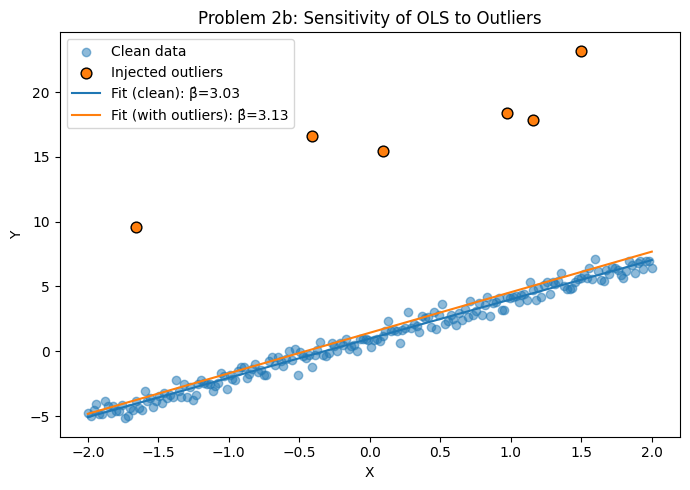

In [17]:
# --- Plot scatter + fitted lines; highlight outliers ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(X, Y_clean, alpha=0.5, label="Clean data")
plt.scatter(X[out_idx], Y_contam[out_idx], s=60, edgecolor="k", label="Injected outliers")
xg = np.linspace(X.min(), X.max(), 200)


plt.plot(xg, m_clean.predict(sm.add_constant(xg)), label=f"Fit (clean): β̂={m_clean.params[1]:.2f}")
plt.plot(xg, m_cont.predict(sm.add_constant(xg)),  label=f"Fit (with outliers): β̂={m_cont.params[1]:.2f}")

plt.title("Problem 2b: Sensitivity of OLS to Outliers")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()
plt.show()

Cook's D threshold ~ 0.0200
High-influence indices (contaminated fit): [17, 79, 104, 148, 157, 174]


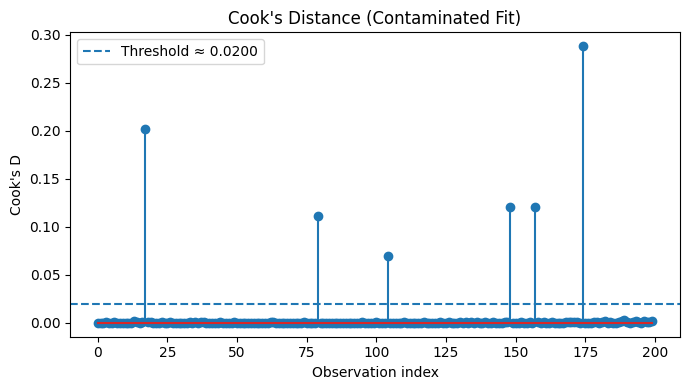

In [19]:
influence = m_cont.get_influence()
cooks_d = influence.cooks_distance[0]

threshold = 4 / n
hi_idx = np.where(cooks_d > threshold)[0]

print(f"Cook's D threshold ~ {threshold:.4f}")
print("High-influence indices (contaminated fit):", hi_idx.tolist())

plt.figure(figsize=(7,4))
plt.stem(np.arange(n), cooks_d)
plt.axhline(threshold, linestyle="--", label=f"Threshold ≈ {threshold:.4f}")
plt.title("Cook's Distance (Contaminated Fit)")
plt.xlabel("Observation index")
plt.ylabel("Cook's D")
plt.legend()
plt.tight_layout()
plt.show()

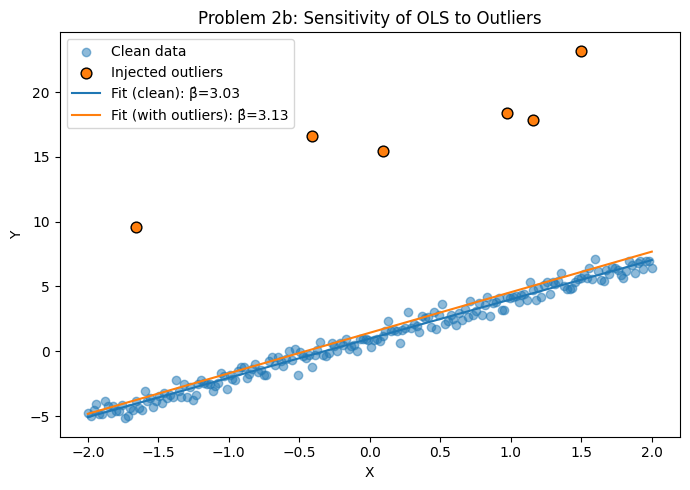

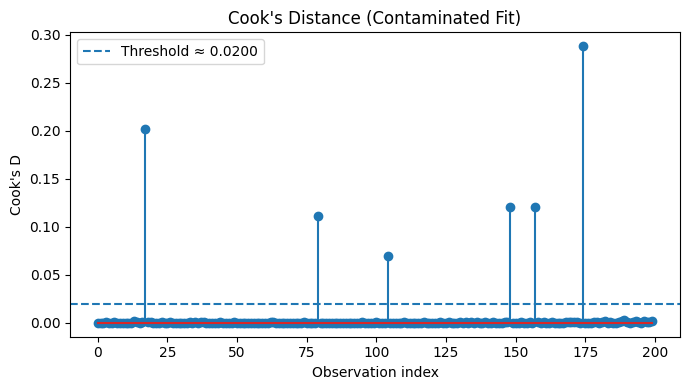

Saved: prob2b_outliers.png, prob2b_cooksD.png


In [21]:
# Re-create the main comparison figure and save under the filename used in your report
plt.figure(figsize=(7,5))
plt.scatter(X, Y_clean, alpha=0.5, label="Clean data")
plt.scatter(X[out_idx], Y_contam[out_idx], s=60, edgecolor="k", label="Injected outliers")
xg = np.linspace(X.min(), X.max(), 200)
plt.plot(xg, m_clean.predict(sm.add_constant(xg)), label=f"Fit (clean): β̂={m_clean.params[1]:.2f}")
plt.plot(xg, m_cont.predict(sm.add_constant(xg)),  label=f"Fit (with outliers): β̂={m_cont.params[1]:.2f}")
plt.title("Problem 2b: Sensitivity of OLS to Outliers")
plt.xlabel("X"); plt.ylabel("Y"); plt.legend(); plt.tight_layout()
plt.savefig("prob2b_outliers.png", dpi=150, bbox_inches="tight")
plt.show()

# Save Cook's D
plt.figure(figsize=(7,4))
plt.stem(np.arange(n), cooks_d)
plt.axhline(threshold, linestyle="--", label=f"Threshold ≈ {threshold:.4f}")
plt.title("Cook's Distance (Contaminated Fit)")
plt.xlabel("Observation index"); plt.ylabel("Cook's D"); plt.legend(); plt.tight_layout()
plt.savefig("prob2b_cooksD.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: prob2b_outliers.png, prob2b_cooksD.png")